### Practice Notebook

Super Deadly dont touch

By Manu Patil and Katie Barno

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
def make_system(pi, Beta, mu, b ,P, N, epsilon, dt):
    """Make a system object for the SBR model.
    S: Susceptible
    B: Bieber-infected
    R: Recovered
    pi: Recruitment Rate
    Beta: Transmission Rate
    mu: Maturation Rate
    b: Boredom Rate
    P: Positive Media Rate
    N: Negative Media Rate
    epsilon: Positive Media Proportion
    
    
    
    returns: System object
    """
    init = State(S = 100, B = 3, R = 0);

    t0 = 0
    t_end = 10
    
    return System(init=init, t0=t0, t_end=t_end,
                  pi =pi, 
                  Beta = Beta, 
                  mu = mu,
                  b  = b,
                  P = P,
                  N = N, 
                  epsilon= epsilon,dt=dt)

In [3]:
def update_func_with_media(state, t, system):
    """Update the SBR model.
    
    state: State (S,B,R)
    t: time
    system: System object
    
    returns: State (S,B,R)
    """
    unpack(system)
    S,B,R = state;
    entranceRate = pi # people that enter the system per month
    infectedRate = Beta*S*B # number of people infected each month
    posMediaPercent = epsilon*P
    negMediaPercent = (1-epsilon)*P
    boredom = b*B
    ds = entranceRate - infectedRate - posMediaPercent*S + negMediaPercent*B + posMediaPercent*R - negMediaPercent*S - mu*S
    db = infectedRate + posMediaPercent*S - negMediaPercent*B - boredom - mu*B # paper says R but should be B
    dr = boredom - posMediaPercent*R + negMediaPercent*S - mu*R
    S += ds* dt
    B += db*dt
    R += dr*dt

    return State(S = S, B = B, R = R);

In [4]:
def update_func_without_media(state, t, system):
    """Update the SBR model.
    
    state: State (S,B,R)
    t: time
    system: System object
    
    returns: State (S,B,R)
    """
    unpack(system)
    S,B,R = state;
    entranceRate = pi # people that enter the system per month
    infectedRate = Beta*S*B # number of people infected each month
    posMediaPercent = epsilon*P
    negMediaPercent = (1-epsilon)*P
    boredom = b*B
    ds = entranceRate - infectedRate  - mu*S
    db = infectedRate - boredom - mu*B # paper says R but should be B
    dr = boredom- mu*R
    S += ds* dt
    B += db*dt
    R += dr*dt

    return State(S = S, B = B, R = R);

In [5]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    
    for t in linrange(t0, t_end, dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

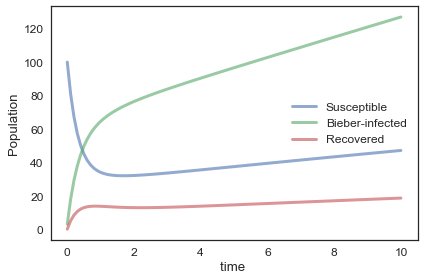

In [6]:
system = make_system(10, .00083, 1/144, 1/24, 2, 1, .75,.1) #Given Parameters and dt set to 1/24 such that time is represented in hours
frame = run_simulation(system, update_func_with_media);
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");

decorate(xlabel = "time ", ylabel = "Population");


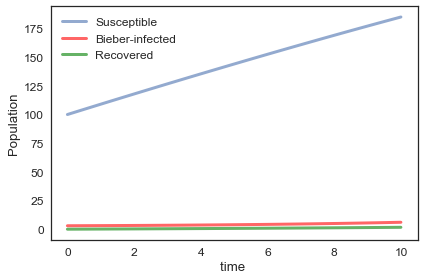

In [7]:
system = make_system(10, .00083, 1/144, 1/24, 2, 1, .75,.1) #Given Parameters and dt set to 1/24 such that time is represented in hours
frame = run_simulation(system, update_func_without_media);
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected",color = "r");
plot(frame.R, label = "Recovered",color= "g");

decorate(xlabel = "time ", ylabel = "Population");

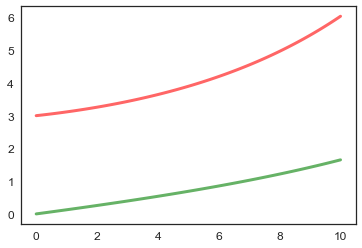

In [8]:
plot(frame.B, label = "Bieber-infected",color = "r");
plot(frame.R, label = "Recovered",color= "g");

In [93]:
def sweep_beta(pi, Beta, mu, b_array ,P, N, epsilon, dt):
    """Sweep a range of values for b.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    sweep[0] = 3
    for b in b_array:
        system = make_system(pi, Beta, mu, b ,P, N, epsilon, dt)
        frame = run_simulation(system, update_func_with_media) # Figure out what we actually want to measure here. Figure out which metric is best
        sweep[system.b] = calc_total_infected(frame.B)
        
    return sweep

In [97]:
def calc_total_infected(results):
    sum = 0
    
    for b in boredom_array:
        change = results[b] - results[b-1] 
        sum += change
    return sum 

In [101]:
boredom_array = linrange(0,2,.02) 
frame = sweep_beta(10, .00083, 1/144, boredom_array, 2, 1, .75,1)

KeyError: -1

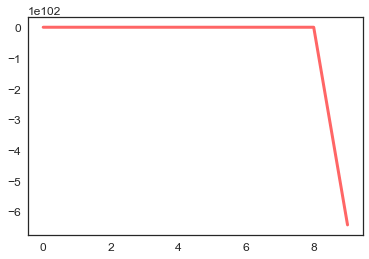

In [85]:
plot(frame, label = "Bieber-infected",color = "r")

In [105]:
def sweep_beta(pi, Beta, mu, b_array ,P, N, epsilon, dt):
    """Sweep a range of values for b.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    sweep[0] = 3
    for b in b_array:
        system = make_system(pi, Beta, mu, b/10 ,P, N, epsilon, dt)
        frame = run_simulation(system, update_func_with_media) # Figure out what we actually want to measure here. Figure out which metric is best
        sweep[system.b] = calc_total_infected(frame.B)
        
    return sweep

In [148]:
def calc_total_infected(results):
    sum = 0
    ten = pd.Series([10])
    
    results2 = results
    results2.append(ten, ignore_index=True)
    
    print(results, results2)
    
    for b in boredom_array:
        change = results[b+1] - results2[b]
        sum += change
    return sum 

In [149]:
boredom_array = linrange(0,200,2) 
frame = sweep_beta(10, .00083, 1/144, boredom_array, 2, 1, .75,1)

0           3
1     151.728
2    -70.6188
3     343.102
4    -507.365
5     743.618
6    -2161.91
7    -2014.08
8    -1012.56
9     938.078
10   -4882.68
Name: B, dtype: object 0           3
1     151.728
2    -70.6188
3     343.102
4    -507.365
5     743.618
6    -2161.91
7    -2014.08
8    -1012.56
9     938.078
10   -4882.68
Name: B, dtype: object


KeyError: 11

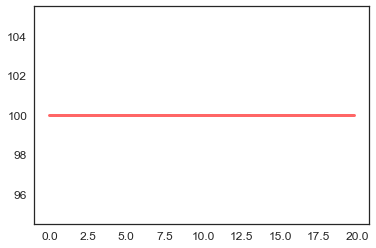

In [135]:
plot(frame, label = "Bieber-infected",color = "r")

### ODE STUFFS

In [25]:
def slope_func(state, t, system):
    """Slope of the SBR model.
    
    state: State (S,B,R)
    t: time
    system: System object
    
    returns: State (S,B,R)
    """
    unpack(system)
    S,B,R = state;
    entranceRate = pi # people that enter the system per month
    infectedRate = Beta*S*B # number of people infected each month
    posMediaPercent = epsilon*P
    negMediaPercent = (1-epsilon)*P
    boredom = b*B
    ds = entranceRate - infectedRate - posMediaPercent*S + negMediaPercent*B + posMediaPercent*R - negMediaPercent*S - mu*S
    db = infectedRate + posMediaPercent*S - negMediaPercent*B - boredom - mu*R # paper says R but should be B
    dr = boredom - posMediaPercent*R + negMediaPercent*S - mu*R
  

    return ds,db,dr;

In [26]:
slope_func(init, 0, system)

(-189.44344444444445, 148.624, 50.125)

In [27]:
system = make_system(10, .00083, 1/144, 1/24, 2, 1, .75,1)
results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,116
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


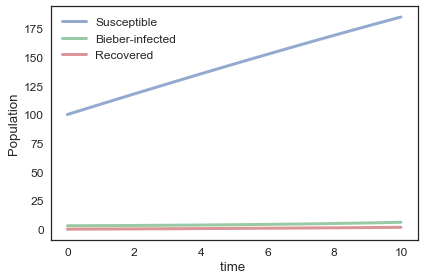

In [28]:

plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");

decorate(xlabel = "time ", ylabel = "Population");